In [89]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
NUM_PX = 64
LAYER_DIMS = [12288, 9, 1] 

In [90]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
def delete_zone_identifier(filenames, directory):
    for filename in filenames:
        try:
            name = filename.split(":")[1]
        except:
            name = ""
        if name == "Zone.Identifier":
            os.remove(directory + "/" + filename)

In [92]:
filenames_train = os.listdir("train/train")
delete_zone_identifier(filenames_train, "train/train")
filenames_test = os.listdir("test1/test1")
delete_zone_identifier(filenames_test, "test1/test1")

In [93]:
def preprocess_image(file_path, target_size):
    image = cv2.imread(file_path)
    image = cv2.resize(image, target_size)
    image = np.array(image, dtype=np.float32)
    image = image / 255.0
    return image

In [94]:
def parse_images(filenames, directory, limit_dogs, limit_cats):
    for filename in filenames:
        category = filename.split('.')[0]
        if category == "dog":
            limit_dogs -= 1
            if limit_dogs < 0:
                os.remove(directory + "/" + filename)
        else:
            limit_cats -= 1
            if limit_cats < 0:
                os.remove(directory + "/" + filename)

In [95]:
filenames_train = os.listdir("train/train")
parse_images(filenames_train, "train/train", 500, 500)
filenames_test = os.listdir("test1/test1")
parse_images(filenames_test, "test1/test1", 100, 100)

In [96]:
def load_dataset(filenames, path, spliter, test="dog"):
    images = []
    labels = []
    for filename in filenames:
        image = preprocess_image(path + filename, (64, 64))
        images.append(image)
        category = filename.split(spliter)[0]
        if category == test:
            labels.append(1)
        else:
            labels.append(0)
    return np.array(images), np.array(labels)

In [97]:
filenames = os.listdir("train/train")
train_set_x_orig, train_set_y = load_dataset(filenames_train, "train/train/", '.')
filenames = os.listdir("test1/test1")
test_set_x_orig, test_set_y = load_dataset(filenames_test, "test1/test1/", '_', '1')

In [98]:
train_set_x = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
train_set_y = train_set_y.reshape(1, train_set_y.shape[0])

In [99]:
train_set_x.shape, train_set_y.shape

((12288, 1000), (1, 1000))

In [100]:
test_set_x_orig.shape, test_set_y.shape

((99, 64, 64, 3), (99,))

In [101]:
test_set_x = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
test_set_y = test_set_y.reshape(1, test_set_y.shape[0])

In [102]:
def initialize_parameters(layer_dims):
    np.random.seed(2)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [103]:
parameters = initialize_parameters(LAYER_DIMS)
print(parameters)

{'W1': array([[-0.00416758, -0.00056267, -0.02136196, ..., -0.01275513,
         0.00733372,  0.01166127],
       [ 0.00016076,  0.00699494, -0.02144254, ..., -0.00569705,
        -0.00276633,  0.0011016 ],
       [-0.00553107,  0.00678748, -0.00870469, ...,  0.00174631,
         0.00395599, -0.00136441],
       ...,
       [ 0.00591403,  0.00618356, -0.00613118, ..., -0.00702644,
         0.00597732,  0.00226512],
       [ 0.00137381,  0.00531559, -0.00411322, ...,  0.00274936,
         0.02391327, -0.00872727],
       [-0.01886398, -0.00101521,  0.00443469, ...,  0.00105953,
         0.0073419 ,  0.00461946]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'W2': array([[-0.01062171, -0.00365029, -0.00166228,  0.00677657,  0.00118906,
        -0.01334242, -0.00662981,  0.00053144,  0.00842811]]), 'b2': array([[0.]])}


In [104]:
def relu(Z):
    cache = Z
    A = np.maximum(0, Z)
    return A, cache

In [105]:
def sigmoid(Z):
    cache = Z
    A = 1 / (1 + np.exp(-Z))
    return A, cache

In [106]:
def linear_forward(A, W, b):
    Z = np.matmul(W, A) + b
    cache = (A, W, b)
    return Z, cache

In [107]:
def linear_activation_forward(prev_A, W, b, activation_function):
    if activation_function == "relu":
        Z, linear_cache = linear_forward(prev_A, W, b)
        A, activation_cache = relu(Z)

    elif activation_function == "sigmoid":
        Z, linear_cache = linear_forward(prev_A, W, b)
        A, activation_cache = sigmoid(Z)
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [108]:
def forward_propagation(X, parameters):
    caches = []
    L = len(parameters) //2
    A = X

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)

    return AL, caches

In [109]:
def cost_function(AL, Y):
    m = Y.shape[1]
    # element1 = np.multiply(Y, np.log(AL))
    # element2 = np.multiply((1 - Y), np.log(1 - AL))
    # cost = (-1 / m) * np.sum(element1 + element2)
    cost = (1./m) * (-np.dot(Y, np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)

    return cost

In [110]:
def relu_backward(dA, activ_cache):
    Z = activ_cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    
    return dZ

In [111]:
def sigmoid_backward(dA, activ_cache):
    Z = activ_cache

    x = 1 / (1 + np.exp(-Z))
    dZ = dA * x * (1-x)

    return dZ

In [112]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1 / m) * np.matmul(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.matmul(W.T, dZ)
    
    return dA_prev, dW, db

In [113]:
def linear_activation_backward(dA, cache, activation_function):
    linear_cache, activ_cache = cache
    if activation_function == "relu":
        dZ = relu_backward(dA, activ_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation_function == "sigmoid":
        dZ = sigmoid_backward(dA, activ_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [114]:
def backward_propagation(AL, Y, caches):
    gradients = {}
    L = len(caches)
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    dA_prev, dW, db = linear_activation_backward(dAL, current_cache, "sigmoid")
    gradients['dA' + str(L-1)] = dA_prev
    gradients['dW' + str(L)] = dW
    gradients['db' + str(L)] = db

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward(gradients['dA'+str(l+1)], current_cache, "relu")
        gradients['dA' + str(l)] = dA_prev
        gradients['dW' + str(l+1)] = dW
        gradients['db' + str(l+1)] = db
    
    return gradients


In [115]:
def update_parameters(parameters, gradients, learning_rate):
    L = len(parameters) // 2
    parameters = parameters.copy()
    for l in range(L):
        parameters['W'+str(l+1)] = parameters['W'+str(l+1)] - learning_rate * gradients['dW'+str(l+1)]
        parameters['b'+str(l+1)] = parameters['b'+str(l+1)] - learning_rate * gradients['db'+str(l+1)]
    return parameters

In [116]:
def DNN_model(X, Y, layer_dims, learning_rate, num_iterations, print_cost):
    
    np.random.seed(2)
    costs = []
    parameters = initialize_parameters(layer_dims)
    for i in range(0, num_iterations):
        AL, caches = forward_propagation(X, parameters)
        cost = cost_function(AL, Y)
        gradients = backward_propagation(AL, Y, caches)
        parameters = update_parameters(parameters, gradients, learning_rate)
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print (f"Cost after iteration {i}: {cost}")
        if print_cost and i % 100 == 0:
            costs.append(cost)
    
    return parameters, costs

In [117]:
parameters, costs = DNN_model(train_set_x, train_set_y, LAYER_DIMS, learning_rate=0.015, num_iterations = 3500, print_cost = True)

Cost after iteration 0: 0.6931600570480898
Cost after iteration 100: 0.6928286349726216
Cost after iteration 200: 0.6921005781191182
Cost after iteration 300: 0.6901979714689298
Cost after iteration 400: 0.6849790522459901
Cost after iteration 500: 0.6711399042434865
Cost after iteration 600: 0.6441204794155085
Cost after iteration 700: 0.6401766394558479
Cost after iteration 800: 0.6285203075067932
Cost after iteration 900: 0.6149692023585595
Cost after iteration 1000: 0.6033817827000728
Cost after iteration 1100: 0.5923305209039623
Cost after iteration 1200: 0.5814788801983484
Cost after iteration 1300: 0.5713403384082029
Cost after iteration 1400: 0.559629111562176
Cost after iteration 1500: 0.5485886747518016
Cost after iteration 1600: 0.539356328876021
Cost after iteration 1700: 0.5283706265258268
Cost after iteration 1800: 0.5169979156419371
Cost after iteration 1900: 0.506655554422082
Cost after iteration 2000: 0.4946311653144705
Cost after iteration 2100: 0.4855561471635498
Cos

In [118]:
def predict(X, Y, parameters):
    AL, caches = forward_propagation(X, parameters)
    n = AL.shape[1]
    predictions = np.zeros((1, n))

    for i in range(1, n):
        if AL[0, i] > 0.5:
            predictions[0, i] = 1
        else:
            predictions[0, i] = 0
    prediction_sum = np.sum((predictions == Y)/n)
    print(f"Accuracy: {str(prediction_sum)}")

In [125]:
predictions_train = predict(train_set_x, train_set_y, parameters)

Accuracy: 0.8320000000000003


In [126]:
predictions_test = predict(test_set_x, test_set_y, parameters)

Accuracy: 0.7777777777777777


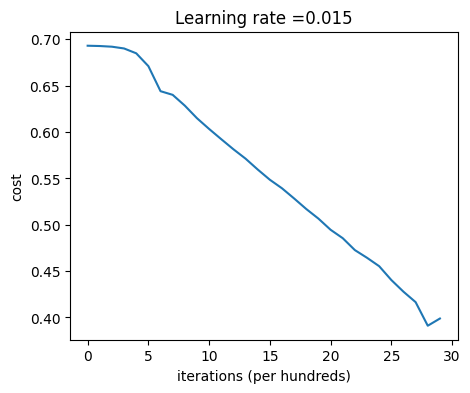

In [127]:
plt.plot(np.squeeze(costs))
plt.xlabel('iterations (per hundreds)')
plt.ylabel('cost')
plt.title("Learning rate =" + str(0.015))
plt.show()